#Лабораторная работа 2. Фабарисов Дмитрий. 2 курс АД

In [94]:
import cv2
import skimage
import skimage.measure as sm
import skimage.io as sk
import matplotlib.pyplot as plt
import numpy as np
import copy as cp
import scipy.fftpack as fft
from skimage.morphology import erosion
from skimage.morphology import disk

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [95]:
def show_pic(pic_list, name = ['picture']*100, figsize_ = (20, 8)):
    fig = figure(figsize = figsize_)
    for idx in range(len(pic_list)):
        subplot = fig.add_subplot(1, len(pic_list), idx+1)
        sk.imshow(pic_list[idx], cmap = 'gray')
        subplot.set_title(name[idx])

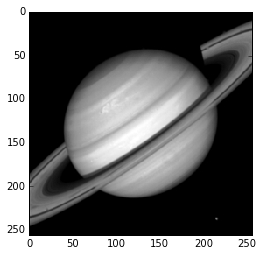

In [96]:
pic = sk.imread('saturn.jpg')
#pic = sk.cvtColor(pic, cv2.COLOR_BGR2GRAY)

sk.imshow(pic)

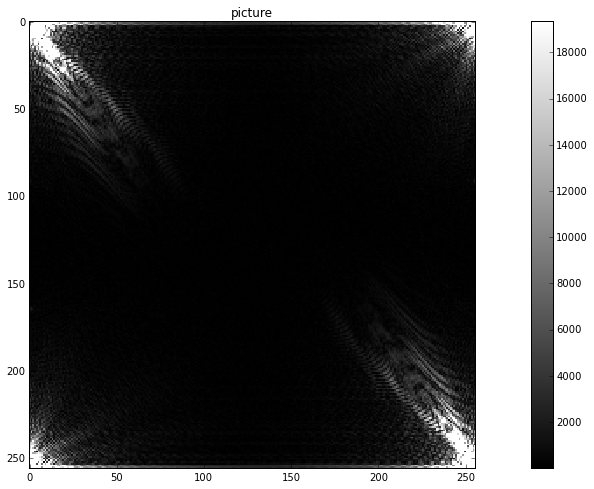

In [97]:
fft_pic = fft.fft2(pic)

fft_abs = np.absolute(fft_pic)
low = np.percentile(fft_abs, 1)
high = np.percentile(fft_abs, 99)

fft_abs[fft_abs < low] = low
fft_abs[fft_abs > high] = high
show_pic([fft_abs])


## 2. Покажем только низкие частоты

(256, 256)


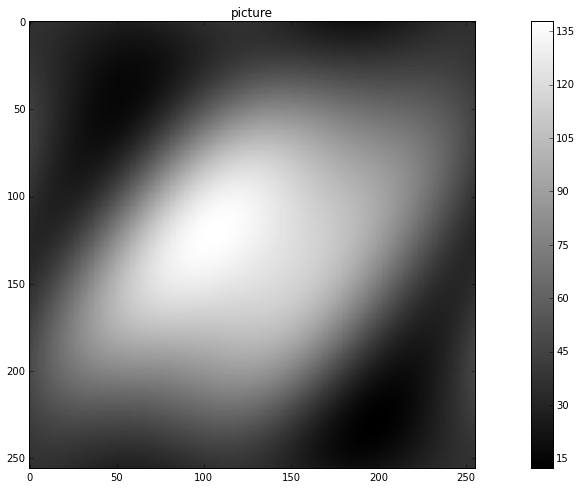

In [98]:
print fft_pic.shape
fft_low = cp.deepcopy(fft_pic)
fft_low[3:,:] = 0
fft_low[:,3:] = 0

pic_low = fft.ifft2(fft_low)

show_pic([np.real(pic_low)])

## 2. Покажем все без низких частот

(256, 256)


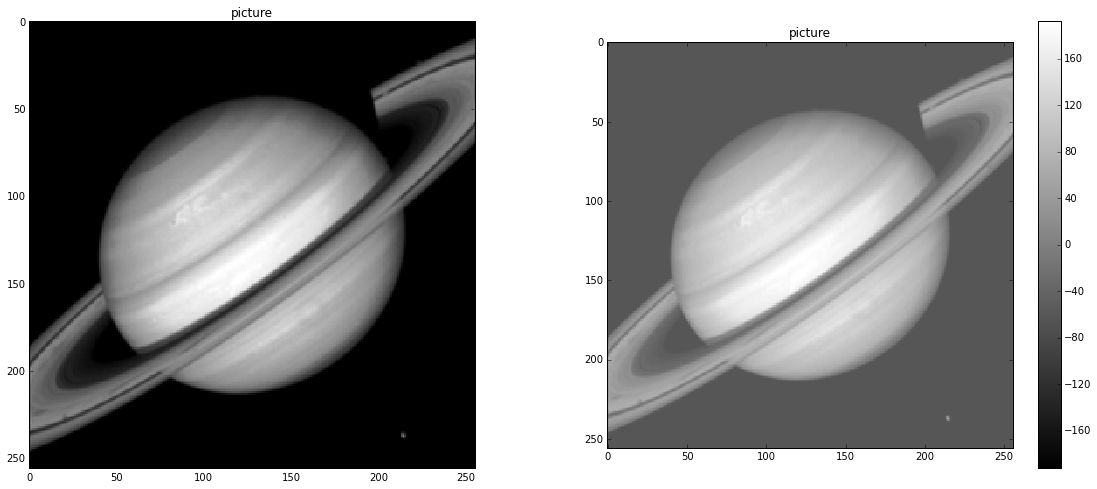

In [99]:
print fft_pic.shape
fft_low = cp.deepcopy(fft_pic)
fft_low[:1:,:1] = 0

pic_low = fft.ifft2(fft_low)

show_pic([pic, np.real(pic_low)])

# Часть 2

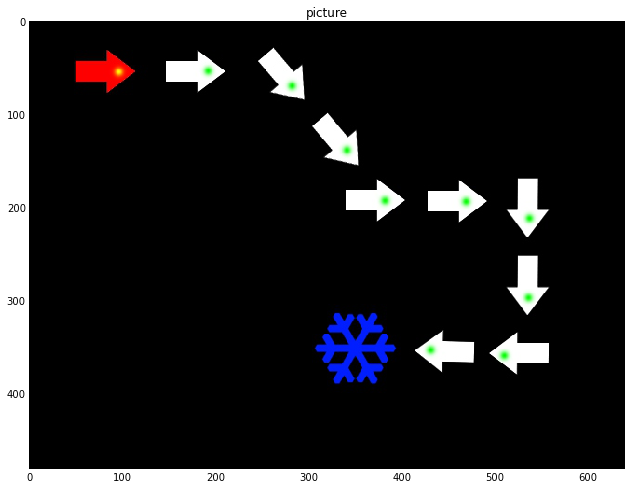

In [100]:
pic_0 = sk.imread('Klad00.jpg')
pic_1 = sk.imread('Klad01.jpg')
pic_2 = sk.imread('Klad02.jpg')
#pics = [pic_0, pic_1, pic_2]
pics = [pic_0]
show_pic(pics)

# 1. Бинаризация изображений

In [101]:
def binarise(pic, koef):
    pic_new = cp.deepcopy(pic)
    pic_new[pic_new >= koef] = 1
    pic_new[pic_new < koef] = 0
    return pic_new


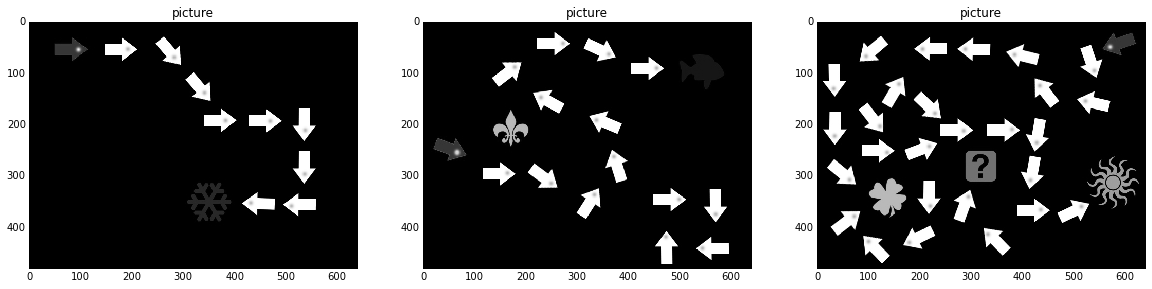

In [102]:
pic_0_gray = skimage.color.rgb2gray(pic_0)
pic_1_gray = skimage.color.rgb2gray(pic_1)
pic_2_gray = skimage.color.rgb2gray(pic_2)

pics_gray = [pic_0_gray, pic_1_gray, pic_2_gray]
show_pic(pics_gray)

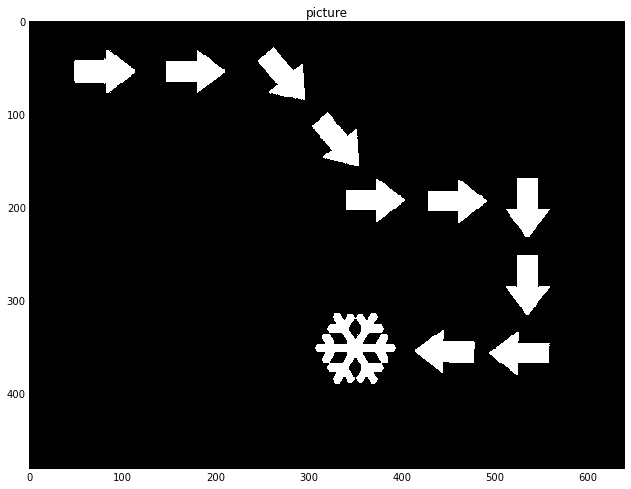

In [103]:
bin_0 = binarise(pic_0_gray, 0.02)
bin_1 = binarise(pic_1_gray, 0.02)
bin_2 = binarise(pic_2_gray, 0.02)
bins = [bin_0]


show_pic(bins)

## 2. Выделяем связанные компоненты

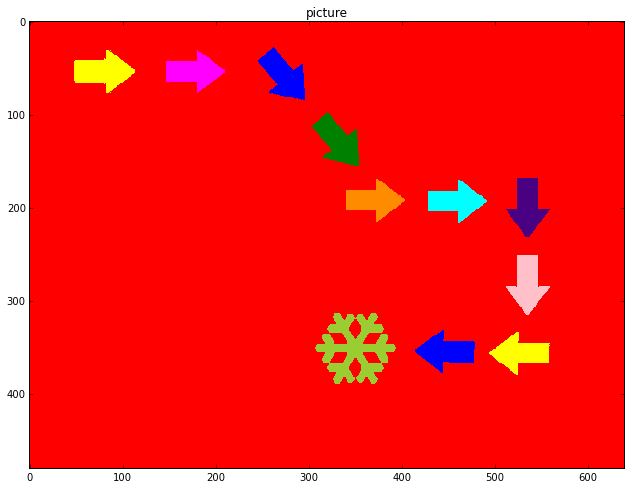

In [104]:
labels_0 = sm.label(bin_0)
labels_1 = sm.label(bin_1)
labels_2 = sm.label(bin_2)

label_0_pic = skimage.color.label2rgb(labels_0)
label_1_pic = skimage.color.label2rgb(labels_1)
label_2_pic = skimage.color.label2rgb(labels_2)

label_pics = [label_0_pic]

show_pic(label_pics)

## 3. Функция для нахождения стрелок (оставляет только стрелки на картинке)

#### Для нахождения стрелок заметим, что они все примерно одинакового размера. Среди всех объектов размером со стрелку будем выделять объекты со схожим эксцентриситетом.

In [162]:
def detect_arrows(label):
    
    min_eccentricity = 0.84
    max_eccentricity = 0.86
    
    min_area = 1400
    max_area = 1700
    
    object_indexes = []
    
    new_label = cp.deepcopy(label)
    objects = skimage.measure.regionprops(label)
    for i in range(0, len(objects)):
        if objects[i].area > max_area or objects[i].area < min_area:
            new_label[new_label == i + 1] = 0
        elif objects[i].eccentricity > max_eccentricity or objects[i].eccentricity < min_eccentricity:
            new_label[new_label == i + 1] = 0
        else
            object_indexes.append(i)
    return object_indexes

In [163]:
new_labels = detect_arrows(labels_0)
print new_labels
#objects = skimage.measure.regionprops(new_labels)
#for i in range(0, len(objects)):
#    print objects[i].orientation, objects[i].bbox

#new_labels = skimage.color.label2rgb(new_labels)
#show_pic([new_labels])

[0, 1, 2, 3, 4, 5, 6, 7, 10, 11]


#### В detect_arrows возвращается массив в котором значения от 0 до много а не от 0 до len(objects), поэтому напишем функцию для компактной перенумерации

In [133]:
def renumerate(labels):
    new_labels = cp.deepcopy(labels)
    maximum_number = np.max(labels)
    if maximum_number == 1:
        return labels
    
    for i in range(1, maximum_number + 1):
        if i not in new_labels:
            if np.max(new_labels) > i:
                new_labels[new_labels == np.max(new_labels)] = i
    return new_labels

In [147]:
arrow_labels = detect_arrows(labels_1)
arrow_labels = renumerate(arrow_labels)

## 4. Находим стартовую красную стрелку

In [110]:
def detect_red_arrow(pic, label):
    red_threshold = 100
    arrow_labels = detect_arrows(label)
    arrow_labels = renumerate(arrow_labels)
    objects = skimage.measure.regionprops(arrow_labels)
    for i in range(0, len(objects)):
        if np.mean(pic[arrow_labels == i+1]) > red_threshold:
            arrow_labels[arrow_labels == i + 1] = 0
    return arrow_labels

## 5. Ищем объект (его метку), на который указывает стрелка

#### Функция get_line_by_angle возвращает массив координат точек по данному направлению, включающий стартовую точку

In [111]:
def check_dot(x, y):
    if x < 0 or x > 639:
        return 0
    if y < 0 or y > 479:
        return 0
    return 1

In [112]:
def get_line_by_angle(angle, start_y, start_x):
    tg_angle = -np.tan(angle)
    line = [[start_y, start_x]]
    cur_left_x = start_x
    cur_right_x = start_x
    cur_left_y = start_y
    cur_right_y = start_y
    
    flag = 1
    # идем направо
    while(flag):
        # смотрим, какой из шагов больше: по вертикали или по горизонтали
        if np.absolute(tg_angle) < 1.0:
            cur_right_x += 1
            delta = np.round(tg_angle*(cur_right_x - start_x))
            
            if check_dot(cur_right_x, start_y + delta):
                line.append([int(start_y + delta), int(cur_right_x)])
            else:
                flag = 0
        # |tg_angle| >= 1.0
        else:
            if tg_angle > 0:
            # идем вправо и вверх
                cur_right_y += 1
            else:
                # идем вправо и вниз
                cur_right_y -= 1
                
            delta = np.round((cur_right_y - start_y) / tg_angle * 1.0)
            if check_dot(start_x + delta, cur_right_y):
                line.append([int(cur_right_y), int(start_x + delta)])
            else:
                flag = 0
         
    flag = 1
    # идем налево
    while(flag):
        # смотрим, какой из шагов больше: по вертикали или по горизонтали
        if np.absolute(tg_angle) < 1.0:
            cur_left_x -= 1
            delta = np.round(tg_angle*(cur_left_x - start_x))
            
            if check_dot(cur_left_x, start_y + delta):
                line.append([int(start_y + delta), int(cur_left_x)])
            else:
                flag = 0
        # |tg_angle| >= 1.0
        else:
            if tg_angle > 0:
            # идем влево и вниз
                cur_left_y -= 1 
            else:
            # идем влево и вверх
                cur_left_y += 1
                
            delta = np.round((cur_left_y - start_y) / tg_angle * 1.0)
            if check_dot(start_x + delta, cur_left_y):
                line.append([int(cur_left_y), int(start_x + delta)])
            else:
                flag = 0
    line = list(line)
    if np.absolute(tg_angle) < 1.0:
        # горизонтально ориентированная линия
        line.sort(key = lambda x: (x[1], x[0]))
    else:
        # вертикально ориентированная линия
        line.sort(key = lambda x: (x[0], x[1]))
    return line

#### У каждой стрелки есть точка другого цвета, с неё то мы и будем стартовать. Функция get_start_dot выдает координаты искомой точки на стрелке. 

In [113]:
def get_start_dot(pic, labels, object_number):
    selem = disk(6)
    labels = erosion(labels, selem)
    l = [labels == object_number + 1][0]
    new_pic = cp.deepcopy(pic)
    coords_y = []
    coords_x = []
    for i in range(479):
        for j in range(639):
            if l[i, j] == True:
                # выделяем зеленые пиксели
                if 2*(pic[i,j][0] + pic[i,j][2]) < pic[i,j][1]:
                    new_pic[i,j] = [0,0,255]
                    coords_y.append(i)
                    coords_x.append(j)
    coords_x = int(np.mean(coords_x))
    coords_y = int(np.mean(coords_y))
    show_pic([new_pic])
    return coords_y, coords_x
    

1544
(212, 536)


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: overflow encountered in ubyte_scalars


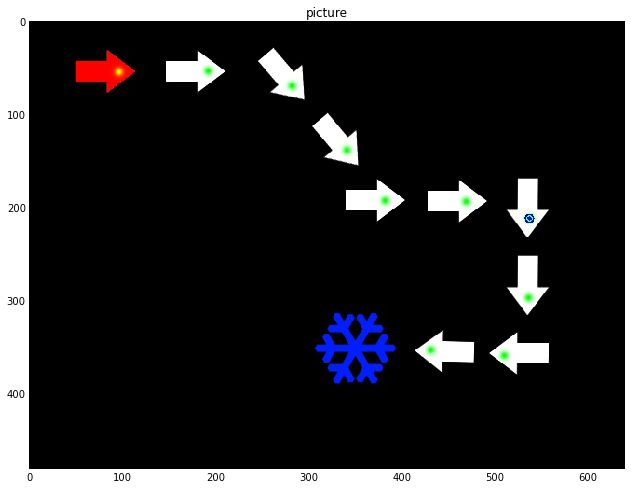

In [115]:
print sum(arrow_labels == 1)
print get_start_dot(pic_0, arrow_labels, 4)

#### Приступаем к написанию функции поиска метки следующего за стрелкой объекта 

#### Стартуя из начальной точки, идем в обе стороны по линии. Стартовая точка всегда ближе к указывающему концу стрелки, поэтому, чтобы определить одно из двух возможных направлений поиска, выберем то, в котором мы быстрее выходим за границу стрелки.

In [116]:
def get_direction_sign(line, labels, start_y, start_x):
    line_index = line.index([start_y, start_x])
    steps = 0
    while(True):
        steps += 1
        if labels[line[line_index + steps][0], line[line_index + steps][1]] == 0:
            return 1
        if labels[line[line_index - steps][0], line[line_index - steps][1]] == 0:
            return -1

1 (29L, 246L, 86L, 296L) (59.2169689119171, 273.13601036269432) -0.868816602731
2 (32L, 48L, 78L, 114L) (54.474637681159422, 79.086956521739125) 0.000198857482379
3 (32L, 147L, 78L, 211L) (54.517148621385338, 176.862138533961) -0.00203023588429
4 (99L, 304L, 156L, 354L) (129.2797157622739, 331.20284237726099) -0.87704183289
5 (169L, 512L, 233L, 559L) (198.95809155383623, 534.98839458413931) 1.56921042988
6 (170L, 340L, 216L, 404L) (192.49630624580254, 369.89053055742107) 0.000533484793234
7 (171L, 428L, 217L, 492L) (193.50201612903226, 457.875) -0.000169787795355
8 (252L, 512L, 316L, 559L) (281.9458064516129, 534.98064516129034) 1.56842430271
9 (334L, 494L, 380L, 559L) (356.45230153435625, 527.16144096064045) 0.0066893528792
10 (332L, 414L, 378L, 479L) (354.54025974025973, 447.44870129870128) -0.0206120733412


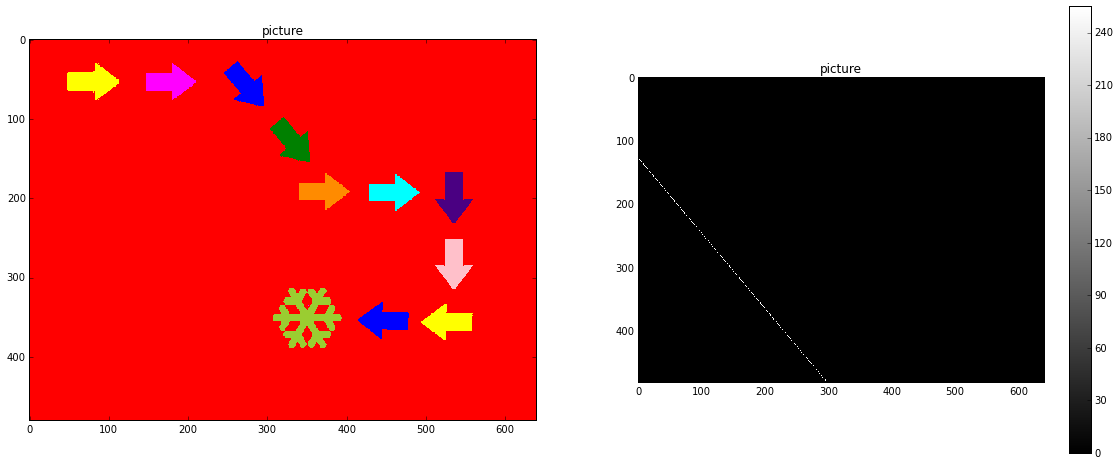

In [117]:
line = get_line_by_angle(-0.87, 192, 54)
new_pic = cp.deepcopy(pic_0)
arrow_labels = detect_arrows(labels_0)
arrow_labels = renumerate(arrow_labels)
objects = skimage.measure.regionprops(arrow_labels)
for i in range(0, len(objects)):
    print i+1, objects[i].bbox, objects[i].centroid, objects[i].orientation
    
for i in range(639):
    for j in range(479):
        if [j, i] in line:
            new_pic[j, i] = [255,255,255]
        else:
            new_pic[j, i] = [0,0,0]
show_pic([skimage.color.label2rgb(labels_0), new_pic])


In [118]:
def get_next_object_number(pic, labels, cur_object_number):
    start_y, start_x = get_start_dot(pic, labels, cur_object_number)
    print "start_y =", start_y, "start_x = ", start_x
    objects = skimage.measure.regionprops(labels)
    angle = objects[cur_object_number].orientation
    print "angle =", angle
    line = get_line_by_angle(angle, start_y, start_x)
    sign = get_direction_sign(line, labels, start_y, start_x)
    line_index = line.index([start_y, start_x])
    
    print "line_index = ", line_index, "start_x = ", line[line_index][1]
    steps = 0
    # выходим за пределы стрелки
    while(True):
        steps += 1
        
        #print line[line_index + steps*sign][0], line[line_index + steps*sign][1]
        
        if labels[line[line_index + steps*sign][0], line[line_index + steps*sign][1]] == 0:
            break
    print "steps = ", steps
    # ищем новый объект
    while (True):
        steps += 1
        
        print "step = ", steps, line[line_index + steps*sign], labels[line[line_index + steps*sign][0], line[line_index + steps*sign][1]]
       
        if labels[line[line_index + steps*sign][0], line[line_index + steps*sign][1]] != 0:
            return labels[line[line_index + steps*sign][0], line[line_index + steps*sign][1]] - 1

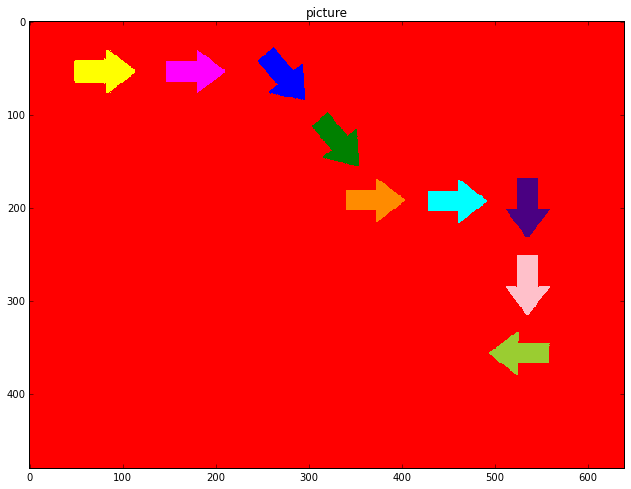

In [158]:
arrow_labels = detect_arrows(labels_0)
arrow_labels = renumerate(arrow_labels)
show_pic([skimage.color.label2rgb(arrow_labels)])

10


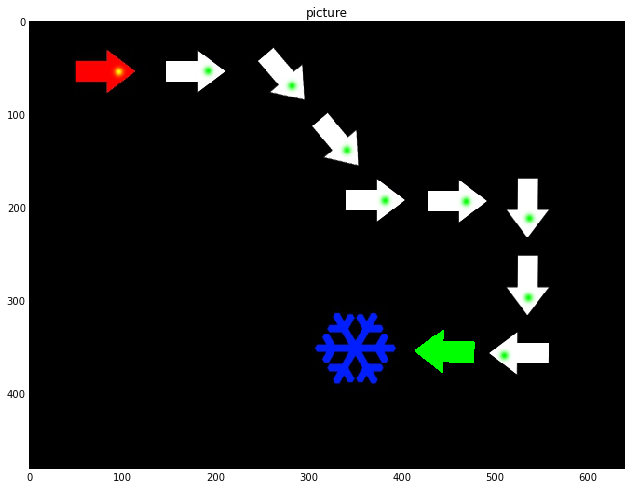

In [136]:
print np.max(arrow_labels)
new_pic = cp.deepcopy(pic_0)
new_pic[arrow_labels == 10] = [0, 255, 0]
show_pic([new_pic])

start_y = 353 start_x =  430
angle = -0.0206120733412
line_index =  430 start_x =  430
steps =  17
step =  18 [353, 412] 0
step =  19 [353, 411] 0
step =  20 [353, 410] 0
step =  21 [353, 409] 0
step =  22 [353, 408] 0
step =  23 [353, 407] 0
step =  24 [353, 406] 0
step =  25 [352, 405] 0
step =  26 [352, 404] 0
step =  27 [352, 403] 0
step =  28 [352, 402] 0
step =  29 [352, 401] 0
step =  30 [352, 400] 0
step =  31 [352, 399] 0
step =  32 [352, 398] 0
step =  33 [352, 397] 0
step =  34 [352, 396] 0
step =  35 [352, 395] 0
step =  36 [352, 394] 0
step =  37 [352, 393] 9
8
9


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: overflow encountered in ubyte_scalars


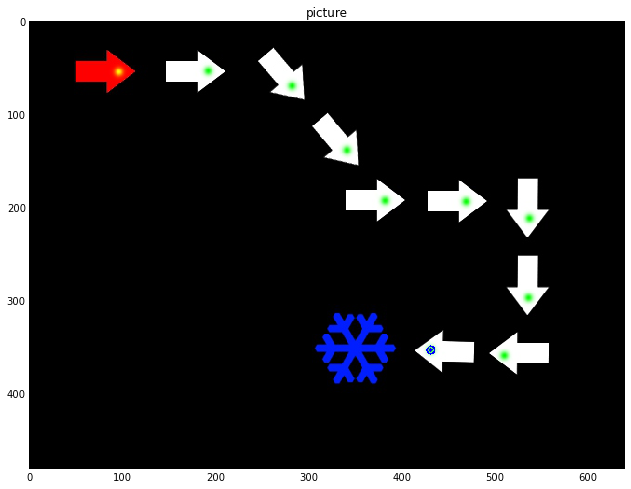

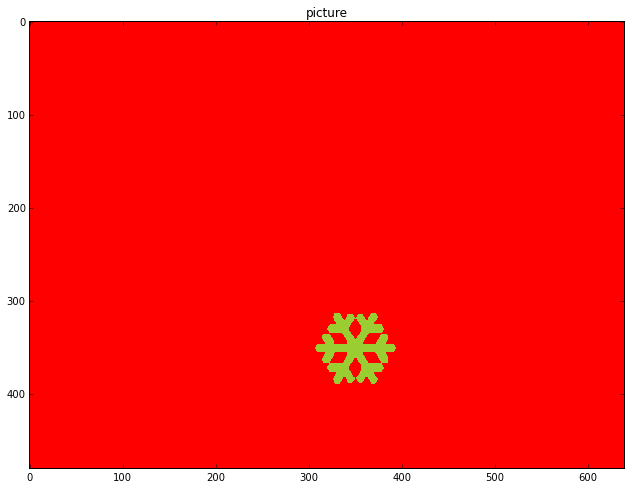

In [157]:

index = get_next_object_number(pic_0, labels_0, 10)
print index
new_labels = cp.deepcopy(labels_0)
new_labels[new_labels != index + 1] = 0
print np.max(new_labels)
show_pic([skimage.color.label2rgb(new_labels)])